In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import random
from joblib import dump
import helper_scripts
import unsupervised_scripts

In [ ]:
### TRAIN MODEL

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2750)): ').strip() or '2750')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(input('Enter HSI step size: ').strip()) 
ch_start = int(input('Enter stack index for 2800 cm^-1 (Default="auto"): ').strip() or str(int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')
shift = 15

## Training Directory (different for everyone)
path_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
data_dir = 'D:/Shi_Lab/Spectral_CLustring/ML/'
sample_dir = data_dir + 'training_data/'+str(num_samp)+'/'

artificial_dataset = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df, shift)
[image_vec, _, _,_] = artificial_dataset.save_srs_params(sample_dir)

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_training_data-65.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_standard = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_standard = preprocessing.spectral_standardization(image_vec)
image_max = np.max(np.percentile(image_standard,99,axis=0))
image_norm = helper_scripts.normalize_manual(image_standard, max_val=image_max, min_val=np.median(image_standard[:,:ch_start]))
image_norm = image_norm-np.median(image_norm[:,:ch_start],axis=1)[0]
X_norm = helper_scripts.normalize(X_standard, max=np.max(image_norm))
X_norm = X_norm-np.median(X_norm[:,:ch_start],axis=1)[0]

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/Shi_Lab/Spectral_CLustring/ML/training_data/'

In [3]:
[mol_norm, _] = artificial_data.molecule_dataset(molecule_df)

NameError: name 'artificial_data' is not defined

Text(0, 0.5, 'Normalized Intensity (A.U.)')

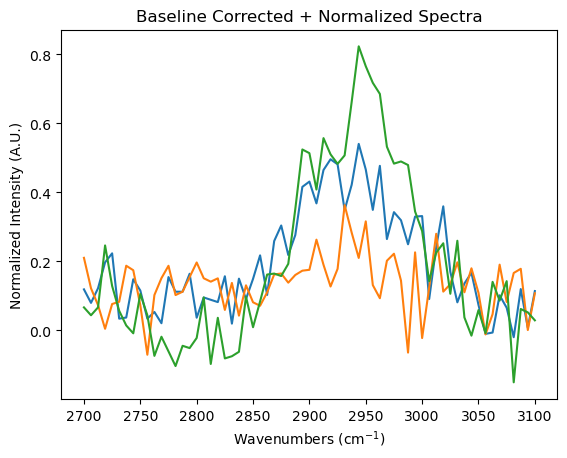

In [11]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

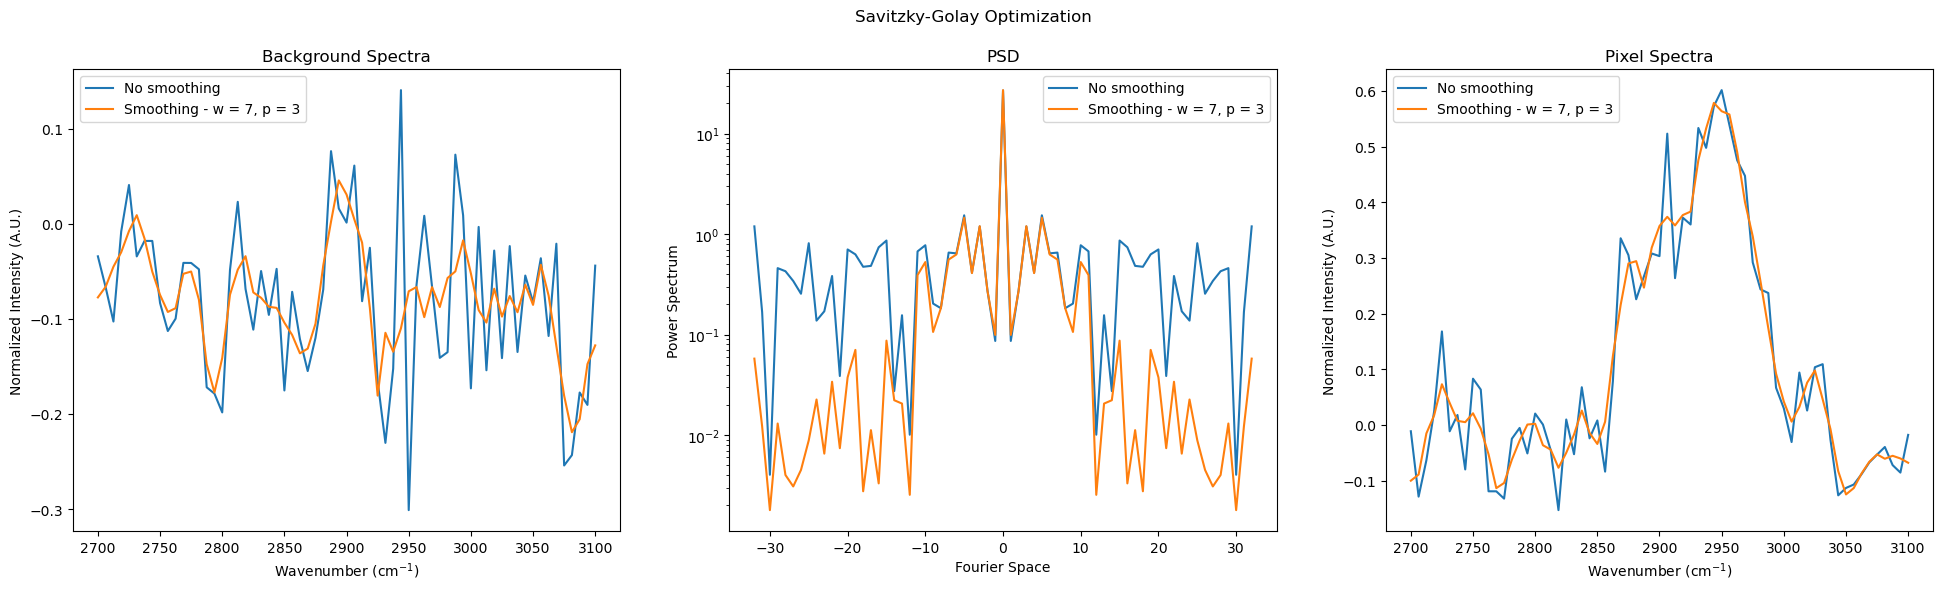

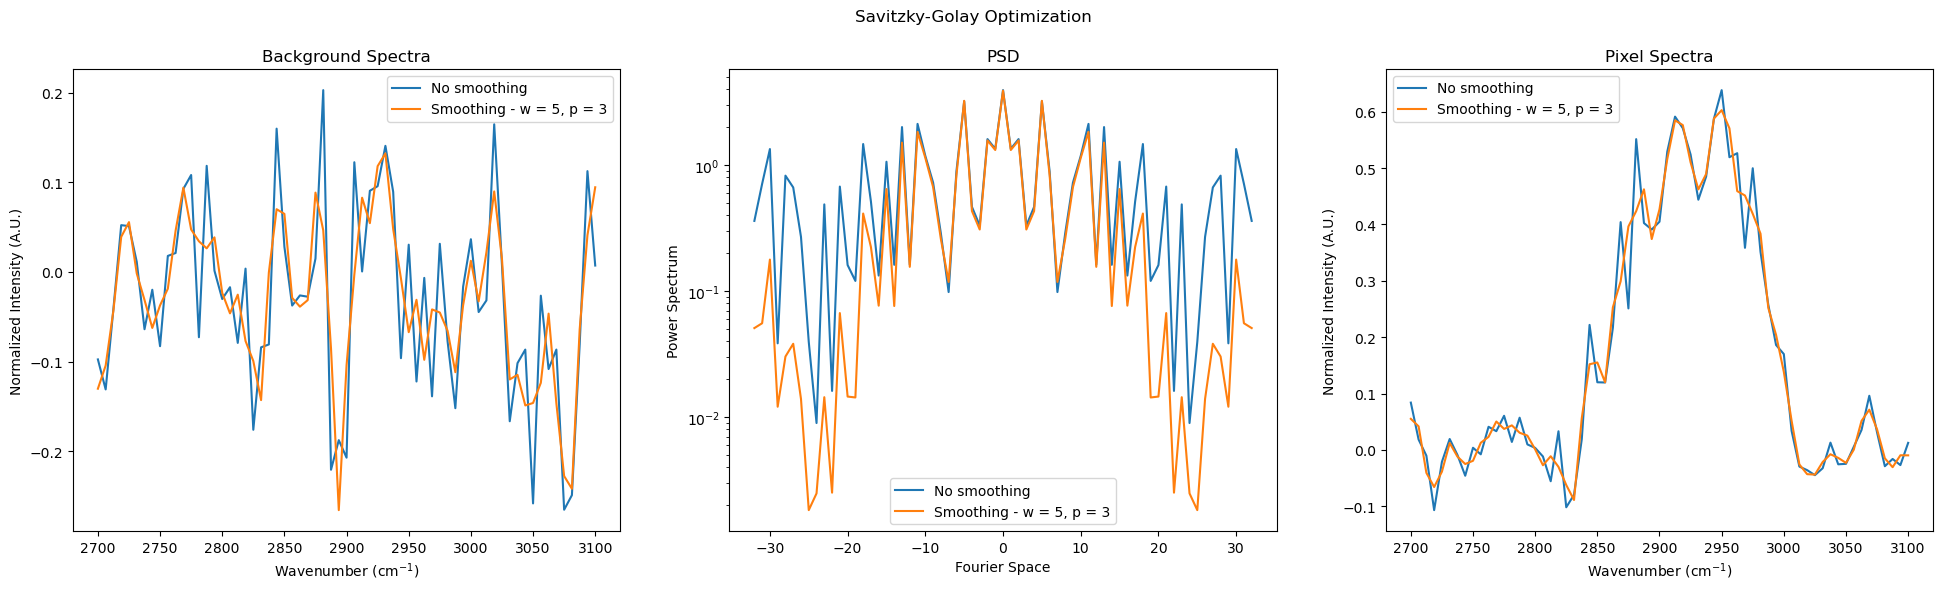

In [13]:
## Optimize Smoothing of HSI and artificial spectra
w = int(input('Enter window size for Savitzky-Golay smoothing (Default=7): ').strip() or '7')
p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
preprocessing.sav_gol_optimization(image_norm, w, p)
preprocessing.sav_gol_optimization(X_norm, w-2, p)
x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
X = savgol_filter(X_norm,w-2,p, axis=1, mode='mirror')

In [ ]:
## Train Random Forest Classifier

rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
rfc = rf_classifier.train(num_estimators=250)
dump(rfc, 'rfc'+str(num_samp)+'.joblib')

['rfc.joblib']